# Import Relevant Libraries

In [1]:
import json
import pandas as pd
import numpy as np
from pandas.io.json import json_normalize
import datetime
import string
import nltk
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt
from math import pi
import time 

# Load Cleaned DataFrame     
Cleaned = no hashtages, web links, @s... no punctuation, lowercase, lemmatized and no stop words

In [2]:
import pickle

with open('cleaned_twitter_df2.pkl', 'rb') as f:
    df = pickle.load(f)

Reset index

In [3]:
df = df.reset_index()

# Load Vader Output

In [4]:
import pickle

with open('vader_output.pkl', 'rb') as f:
    vader_output = pickle.load(f)

Convert vader outputs to a dataframe

In [5]:
df_sentiment = json_normalize(vader_output)

Append vader outputs to original dataframe

In [6]:
df = pd.concat([df, df_sentiment], axis=1)

# Trend Lines

Turn .time. column into a timestamp of hours, minutes, seconds

In [7]:
df['.time.'] = df['timestamp_ms'].apply(lambda x: time.strftime('%H:%M:%S', time.gmtime(int(x)/1000)))

List of every unique second in the data

In [8]:
def unique_seconds_list():
    unique_seconds = []
    for times in df['.time.']:
        all_times = []
        all_times.append(times)
        for i in all_times:
            if not i in unique_seconds:
                unique_seconds.append(i)
    return unique_seconds

Create a list that groups each second into either 5 seconds, 15 seconds, 30 seconds, etc.

In [9]:
def second_groupings(seconds=5):
    second_groups = []
    for second in unique_seconds_list():
        if len(second_groups)==0:
            second_groups.append(1)
        elif len(second_groups)%seconds != 0:
            second_groups.append(second_groups[-1])
        else:
            second_groups.append(second_groups[-1]+1)
    return second_groups

#five sec 5 - fifteen sec 15 - thirty sec 30 - 
#one min 60 - two min 120 - three min 180
#five min 300 - ten min 600 - fifteen min 900
#twenty min 1200 - thirty min 1800 - forty min 2400
#fifty min 3000 - sixty min 3600

Turn the above list into a dictionary

In [10]:
def seconds_dict(seconds=5):
    second_dict = dict(zip(unique_seconds_list(), second_groupings(seconds)))
    return second_dict

Append dictionaries to the dataframe in new columns

In [11]:
all_relevant_seconds_for_grouping = [5,15,30,60,120,180,300,600,900,
                                     1200,1800,2400,3000,3600]

for i in all_relevant_seconds_for_grouping:
    df[str(i)+'_seconds'] = df['.time.'].map(seconds_dict(i))

Create SUM Trend Lines (5 second intervals)

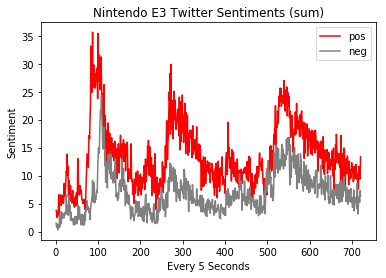

In [12]:
five_sum_df = df.groupby('5_seconds').sum()
five_sum_df = five_sum_df.reset_index()

plt.plot(five_sum_df['5_seconds'], five_sum_df['pos'], color='red')
plt.plot(five_sum_df['5_seconds'], five_sum_df['neg'], color='grey')
plt.xlabel('Every 5 Seconds')
plt.ylabel('Sentiment')
plt.title('Nintendo E3 Twitter Sentiments (sum)')
plt.legend()
plt.show()

Create MEAN Trend Lines (5 second intervals)

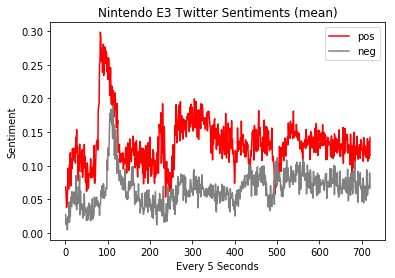

In [13]:
five_mean_df = df.groupby('5_seconds').mean()
five_mean_df = five_mean_df.reset_index()

plt.plot(five_mean_df['5_seconds'], five_mean_df['pos'], color='red')
plt.plot(five_mean_df['5_seconds'], five_mean_df['neg'], color='grey')
plt.xlabel('Every 5 Seconds')
plt.ylabel('Sentiment')
plt.title('Nintendo E3 Twitter Sentiments (mean)')
plt.legend()
plt.show()

# Words DataFrame
### To be used for top positive/negative words (radar plots)

In [14]:
def unique_words_list(df):
    total_words = []
    for i in df['text2']:
        words = i.split()
        for j in words:
            total_words.append(j)

    unique_words = [] 
    for i in total_words:
        if not i in unique_words:
            unique_words.append(i)
    return unique_words

In [15]:
def vectorize_to_df():
    vectorizer = CountVectorizer(vocabulary=unique_words_list(df))
    vectorized_words = vectorizer.transform(df['text2'])
    word_array = vectorized_words.toarray()
    matrix_df = pd.DataFrame(word_array, columns=unique_words_list(df), index=df.index) 
    return matrix_df

In [16]:
def words_df(df):
    df = df.rename(index=str, columns={"text": ".text.", "lang": ".lang.", "time":".time."})
    df = df.drop('index', 1)
    df = df.reset_index()
    df = df.rename(index=str, columns={'index': 'df_index'})
    matrix_df = vectorize_to_df().reset_index()
    matrix_df = matrix_df.rename(index=str, columns={'index': 'matrix_df_index'})
    df_words = df.join(matrix_df)
    return df_words

In [17]:
words_df = words_df(df)

# Top Words for Positive/Negative Sentiments

There are duplicate .time. columns, remove and replace

In [18]:
words_df = words_df.drop('.time.', axis=1)
words_df['.time.'] = words_df['timestamp_ms'].apply(lambda x: time.strftime('%H:%M:%S', time.gmtime(int(x)/1000)))

Create dictionary of top 5 positive/negative words

In [19]:
def create_dictionary_for_specified_time (time=1, which_five='top'): # choose either 'top' or 'bottom'
    df_filtered_by_seconds = words_df.loc[(words_df['5_seconds']== time)]  #| (df_words['five_seconds']== 2)]
    dict_by_seconds = df_filtered_by_seconds.to_dict(orient='index')
    
    # create a cleaned dictionary for each word labeled by tweet number
    list_of_word_dicts = []
    for key1, val in dict_by_seconds.items():
        u_words = val['text2'].split(' ')
        neg = val['neg']
        compound = val['compound']
        neu = val['neu']
        pos = val['pos']
        for key, value in val.items():
            try:
                value = float(value)
                if (value > 0) & (key in u_words) :
                    list_of_word_dicts.append({ 
                            'tweet_no': key1,
                            key:{'count': 1, 'compound_sum': compound, 'neg_sum': neg, 
                                 'neu_sum': neu, 'pos_sum': pos},
                                                })
            except:
                pass
    
    # remove duplicate words that appear several times in one tweet
    no_dupl_list_of_word_dicts = [i for n, i in enumerate(list_of_word_dicts) 
                                  if i not in list_of_word_dicts[n + 1:]]
    
    return_dict = {}
    for i in no_dupl_list_of_word_dicts:
        for key, val in i.items():
            if key is not 'tweet_no':
                if key not in return_dict.keys():
                    return_dict.update({key : val})
                else:
                    return_dict[key]['count'] += val['count']
                    return_dict[key]['compound_sum'] += val['compound_sum']
                    return_dict[key]['neg_sum'] += val['neg_sum']
                    return_dict[key]['neu_sum'] += val['neu_sum']
                    return_dict[key]['pos_sum'] += val['pos_sum']
                    
    compound_dict = {}
    for key, val in return_dict.items():
        #print(key, val)
        #compound_dict.update({key: val['compound_sum'] })
        compound_dict[key] = val['compound_sum']
    
    sorted_compound_dict = sorted(compound_dict.items(), key=lambda kv: kv[1])
    
    if which_five == 'top':
        #five_words = dict(sorted_compound_dict[0:5])
        five_words = dict(sorted_compound_dict[-5:])
    elif which_five == 'bottom': 
        #five_words = dict(sorted_compound_dict[-5:])
        five_words = dict(sorted_compound_dict[0:5])
    else:
        "Please choose either 'top' or 'bottom'."

    return five_words

In [20]:
def top_5_dict_to_df(which_five='top'):  
    top_5_df = pd.Series(create_dictionary_for_specified_time(which_five=which_five))
    top_5_df = pd.DataFrame(top_5_df)
    top_5_df = top_5_df.T
    top_5_df['group'] = 'A'
    return top_5_df

In [21]:
#MODIFY ABOVE FUCTION FOR VARIOUS TIME SLOTS
create_dictionary_for_specified_time(1, 'top')

{'like': 1.1699,
 'time': 1.2008,
 'ready': 1.6520000000000001,
 'body': 1.8051,
 'nintendo': 2.494}

In [22]:
top_5_dict_to_df()

,like,time,ready,body,nintendo,group
0,1.1699,1.2008,1.652,1.8051,2.494,A


# Radar Plots

In [23]:
top_5_dict_to_df('top')

,like,time,ready,body,nintendo,group
0,1.1699,1.2008,1.652,1.8051,2.494,A


In [37]:
def radar_plot_creator(which_five='top'):
   # Set data
    radar_df_test = top_5_dict_to_df(which_five)

    # number of variable
    categories=list(radar_df_test)[1:]
    N = len(categories)

    # We are going to plot the first line of the data frame.
    # But we need to repeat the first value to close the circular graph:
    values=radar_df_test.loc[0].drop('group').values.flatten().tolist()
    values += values[:1]
    values

    # What will be the angle of each axis in the plot? (we divide the plot / number of variable)
    angles = [n / float(N) * 2 * pi for n in range(N)]
    angles += angles[:1]

    # Initialise the spider plot
    ax = plt.subplot(111, polar=True)

    # Draw one axe per variable + add labels labels yet
    plt.xticks(angles[:-1], categories, color='grey', size=8)

    # Draw ylabels
    ax.set_rlabel_position(0)
    plt.yticks([-3,-2,-1,0,1,2,3], ["","","", 0, "", "", ""], color="grey", size=7)
    plt.ylim(-3,3)

    # Plot data
    if which_five == 'top':
        ax.plot(angles, values, linewidth=1, linestyle='solid', color='red')
    elif which_five == 'bottom':
        ax.plot(angles, values, linewidth=1, linestyle='solid', color='grey')

    # Fill area
    if which_five == 'top':
        testing_radar = ax.fill(angles, values, 'red', alpha=0.1);  
    elif which_five == 'bottom':
        testing_radar = ax.fill(angles, values, 'grey', alpha=0.1);  
    
    return testing_radar

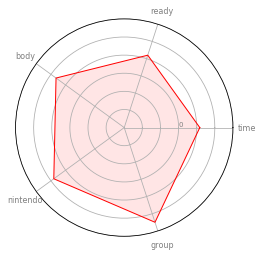

In [38]:
radar_plot_creator()